This file contains the code for paper [**Easy Transfer Learning By Exploiting Intra-domain Structures**](https://arxiv.org/pdf/1904.01376.pdf) published at **IEEE International Conference on Multimedia & Expo (ICME) 2019.**

## Packags

Let's first import all the packages that we will need during this project.

In [1]:
import os
import pulp
import time
import scipy
import seaborn
import scipy.io
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
seaborn.set()

## Intra-domain Programming

At first, we implement intra-domain programming. To do this, we follow the 4 steps below:
1. calculate the class center $h_c$ in source domain.
2. Calculate distance matrix $D$.
3. Obtain Probability Annotation Matrix $M$ by solving learning objective.
4. Obtain label of target domain by the softmax function.


### step 1

Here is the formula we use to compute $h$ a vector of class center in source domain:

$$h_c=\frac{1}{\left|\mathrm{\Omega}_s^{\left(c\right)}\right|}\sum_{i}^{n_s}{x_i^s.\ \mathbb{I}\left(y_i^s=c\right)}$$


In [2]:
def get_class_center(Xs, Ys):
    """
    calculate the class center h in source domain.

    Arguments:
    Xs -- features of source domain
    Ys -- labels of source domain
    
    Return:
    class_center -- class center vector of source domain
    
    """
    class_center = []
    classes = np.unique(Ys)

    for c in classes:
        mask = Ys == c
        Xi = Xs[mask.flatten()]
        hc = np.mean(Xi, axis=0)
        class_center.append(hc)
        
    class_center = np.asarray(class_center)
    
    return class_center

### step 2

Here is the formula we use to compute $D_{cj}$ an entry in a distance matrix $D$:

$$D_{cj}\ =\ \left|\left|x_{{tj}}\ -\ h_c\right|\right|$$

In [3]:
def get_distance_matrix(Xt, class_center):
    """
    calculate the distance matrix D.

    Arguments:
    Xt -- features of target domain
    class_center -- class centers of source domain
    
    Return:
    D -- distance matrix
    
    """
    nt = Xt.shape[0]
    C = class_center.shape[0]

    D = np.zeros((C, nt))

    for i, hc in enumerate(class_center):
        for j, xt in enumerate(Xt):
            d = np.linalg.norm(xt - hc)
            D[i][j] = d

    return D

### step 3 and 4

To obtain Probability Annotation Matrix $M$, we must solve the below laerning objective via PuLP package:

$$min\ \ \ \ \mathbf{J}=\ \sum_{j}^{n_t}\sum_{c}^{C}{D_{cj}}M_{cj} \ \ \ s.t $$
$$ 0\le\ M_cj\le1, \\ \sum_{c}^{C}M_{cj}=1,\ \forall\ j\ \epsilon\ 1,\ \ldots,\ n_t, \\ \sum_{j}^{n_t}M_{cj}\geq1,\ \forall\ c\ \epsilon\ 1,\ \ldots,C $$


In [4]:
def solve_LP(C, nt, Dcj):
    """
    solve the laerning objective.

    Arguments:
    C -- number of classes
    nt -- number of examples in target domain
    Dcj -- distance matrix
    
    Return:
    output -- Probability Annotation Matrix
    
    """
    Dcj = abs(Dcj)
    model = pulp.LpProblem('Cost_minimizing_problem', pulp.LpMinimize)
    Mcj = pulp.LpVariable.dicts('Probabality',
                                ((i, j) for i in range(C) for j in range(nt)),
                                lowBound=0,
                                upBound=1,
                                cat='continous')
    # Objective function
    model += (pulp.lpSum(Dcj[(i, j)] * Mcj[(i, j)] for i in range(C)
                         for j in range(nt)))

    # Constarints
    for j in range(nt):
        model += pulp.lpSum([Mcj[(i, j)] for i in range(C)]) == 1

    for i in range(C):
        model += pulp.lpSum([Mcj[(i, j)] for j in range(nt)]) >= 1

    # Solve the problem
    model.solve()
    pulp.LpStatus[model.status]
    output = [[Mcj[i, j].varValue for i in range(C)] for j in range(nt)]

    return np.array(output)

###  Merge all functions

Now, we gather all three functions above into a intra_domain_programming  function.

In [5]:
def intra_domain_programming(Xs, Ys, Xt, Yt):
    """
    implement the intra_domain programming method.
    
    Arguments:
    Xs -- features of source domain
    Ys -- labels of source domain
    Xt -- features of target domain
    Yt -- labels of target domain
    
    Return:
    y_pred -- predicted labels of target domain
    acc -- accuracy of method
    
    """
    C = len(np.unique(Ys))
    nt = len(Yt)

    class_center = get_class_center(Xs, Ys)
    D = get_distance_matrix(Xt, class_center)
    Mcj = solve_LP(C, nt, D)

    y_pred = np.argmax(Mcj, axis=1)
    acc = np.mean(y_pred == Yt.flatten())

    return y_pred, acc

## Intra_domain Alignment

To align domains, we choose CORAL for its computational efficiency and that it contains no other parameters to tune.

$$  x_{snew}= x^r.\ {(cov\left(x^s\right)+E_s)}^{-\frac{1}{2}}.{(cov\left(x^t\right)+E_t)}^\frac{1}{2} $$

In [6]:
def intra_domain_alignment(Xs, Xt):
    """
    implement the intra_domain alignment method.
    
    Arguments:
    Xs -- features of source domain
    Xt -- features of target domain
    
    Return:
    Xs_new -- aligned features of source domain
    
    """
    cov_src = np.ma.cov(Xs.T)
    cov_tar = np.ma.cov(Xt.T)

    Es = np.eye(Xs.shape[1])
    Et = np.eye(Xt.shape[1])

    Cs = scipy.linalg.sqrtm(np.linalg.inv(np.array(cov_src + Es)))
    Ct = scipy.linalg.sqrtm(np.array(cov_tar + Et))

    coral = np.dot(Cs, Ct)

    Xs_new = np.dot(Xs, coral)
    return Xs_new

## EasyTL

In [7]:
def EasyTL(Xs, Ys, Xt, Yt):
    Xs = intra_domain_alignment(Xs, Xt)
    y_pred, acc = intra_domain_programming(Xs, Ys, Xt, Yt)

    return y_pred, acc

In [8]:
def EasyTL_without_alignment(Xs, Ys, Xt, Yt):
    y_pred, acc = intra_domain_programming(Xs, Ys, Xt, Yt)

    return y_pred, acc

## Experiments

Before run the below cells, please, download these 4 popular TL datasets and save them into **Datasets** directory:
1. [Amazon Review dataset](https://mega.nz/folder/RS43DADD#4pWwFA0CBJP1oLhAR23bTA)
2. [Office-Caltech with SURF features](https://mega.nz/folder/AaJTGIzD#XHM2XMsSd9V-ljVi0EtvFg)
3. [Image-CLEF ResNet-50 pretrained features](https://mega.nz/folder/QPJCzShS#b6qQUXWnCCGBMVs0m6MdQw)
4. [Office-Home ResNet-50 pretrained features](https://mega.nz/folder/pGIkjIxC#MDD3ps6RzTXWobMfHh0Slw)

In [9]:
def plot_result_table(task, EasyTL_Acc, EasyTL_without_alignment_Acc, title):
    """
    plot a table of accuracy.
    
    Arguments:
    task -- a list of cross domain
    EasyTL_Acc -- a list of accuracy on different domains with EasyTL method
    EasyTL_without_alignment_Acc -- a list of accuracy on different domains with EasyTL method without alignment
    title -- tilte of table
    
    Return:
    show plot
    
    """
    
    df = pd.DataFrame({
        'Task': task,
        'EasyTL': EasyTL_Acc,
        'EasyTL\nwithout\nalignment': EasyTL_without_alignment_Acc
    })[['Task', 'EasyTL', 'EasyTL\nwithout\nalignment']]

    table = plt.table(cellText=df.values,
                      colWidths=[0.35, 0.15, 0.18],
                      colLabels=df.columns,
                      cellLoc='center',
                      loc='upper center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)

    for i in range(0, 3):
        table[(0, i)].set_height(.2)
        table[(0, i)].set_fontsize(12)
        table[(0, i)].set_text_props(fontweight="bold")

    for i in range(len(task) + 1):
        for j in range(0, 3):
            if i == 0:
                table[(i, j)].set_facecolor("#6886c5")
            elif i % 3 == 0:
                table[(i, j)].set_facecolor("#ffacb7")
            elif i % 3 == 1:
                table[(i, j)].set_facecolor("#ffe0ac")
            else:
                table[(i, j)].set_facecolor("#f9f9f9")

    plt.title(title, fontweight="bold")
    plt.axis('off')

    plt.savefig(title + '.jpg', bbox_inches="tight", dpi=300)

    plt.show()

In [25]:
def plot_bar_chart(task, EasyTL, EasyTL_without_alignment, title, accuracy = True):
    """
    plot a bar chart of accuracy.
    
    Arguments:
    task -- a list of cross domain
    EasyTL_Acc -- a list of accuracy on different domains with EasyTL method
    EasyTL_without_alignment_Acc -- a list of accuracy on different domains with EasyTL method without alignment
    title -- tilte of table
    
    Return:
    show bar chart
    
    """
    index = np.arange(len(task))
    bar_width = 0.35

    if accuracy:
        EasyTL = [float(i.strip(' %')) for i in EasyTL]
        EasyTL_without_alignment = [
            float(i.strip(' %')) for i in EasyTL_without_alignment
        ]
    else:
        EasyTL = [float(i.strip(' sec')) for i in EasyTL]
        EasyTL_without_alignment = [
            float(i.strip(' sec')) for i in EasyTL_without_alignment
        ]
        

    plt.bar(index,
            EasyTL,
            bar_width,
            color='#ffacb7',
            label='EasyTL',
            alpha=0.8)
    plt.bar(index + bar_width,
            EasyTL_without_alignment,
            bar_width,
            color='#6886c5',
            label='EasyTL without alignment',
            alpha=0.8)

    plt.xlabel('task')
    
    if accuracy:
        plt.ylabel('accuracy')
    else:
        plt.ylabel('time(sec)')
        
    plt.title(title)
    plt.xticks(index + bar_width, task, rotation='vertical')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.savefig(title + '.jpg', bbox_inches="tight", dpi=150)
    
    plt.show()

### Amazon Review dataset

In [23]:
datadir = 'Datasets/amazon_review/'
domain = ['books', 'dvd', 'elec', 'kitchen']
task = []

EasyTL_Acc = []
EasyTL_time = []

EasyTL_without_alignment_Acc = []
EasyTL_without_alignment_time = []

for i in range(len(domain)):
    for j in range(len(domain)):
        if i == j:
            continue
        print("{} - {}".format(domain[i], domain[j]))
        task.append("{} - {}".format(domain[i], domain[j]))
        
        mat1 = scipy.io.loadmat(datadir + '/{}_400.mat'.format(domain[i]))
        mat2 = scipy.io.loadmat(datadir + '/{}_400.mat'.format(domain[j]))

        Xs = mat1['fts']
        Ys = mat1['labels']

        Xt = mat2['fts']
        Yt = mat2['labels']

        # Normalize Data
        Xs = Xs / np.tile(np.sum(Xs, axis=1).reshape(-1, 1), [1, Xs.shape[1]])
        Xs = scipy.stats.mstats.zscore(Xs)
        
        Xt = Xt / np.tile(np.sum(Xt, axis=1).reshape(-1, 1), [1, Xt.shape[1]])
        Xt = scipy.stats.mstats.zscore(Xt)
        
        Xs[np.isnan(Xs)] = 0
        Xt[np.isnan(Xt)] = 0

        t0 = time.time()
        _, Acc = EasyTL(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_time.append('{:.2f}'.format(t1 - t0))
        
        t0 = time.time()
        _, Acc = EasyTL_without_alignment(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL without alignment Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL without alignment Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_without_alignment_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_without_alignment_time.append('{:.2f}'.format(t1 - t0))
        
        print ('\n' + "-------------------------------------------------------" + '\n')

books - dvd


C:\Users\maryam\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


EasyTL Time Elapsed: 1.63 sec
EasyTL Acc: 79.8 %
EasyTL without alignment Time Elapsed: 0.45 sec
EasyTL without alignment Acc: 78.4 %

-------------------------------------------------------

books - elec
EasyTL Time Elapsed: 1.51 sec
EasyTL Acc: 79.7 %
EasyTL without alignment Time Elapsed: 0.75 sec
EasyTL without alignment Acc: 77.5 %

-------------------------------------------------------

books - kitchen
EasyTL Time Elapsed: 2.38 sec
EasyTL Acc: 80.9 %
EasyTL without alignment Time Elapsed: 0.77 sec
EasyTL without alignment Acc: 79.2 %

-------------------------------------------------------

dvd - books
EasyTL Time Elapsed: 1.69 sec
EasyTL Acc: 79.9 %
EasyTL without alignment Time Elapsed: 0.44 sec
EasyTL without alignment Acc: 79.5 %

-------------------------------------------------------

dvd - elec
EasyTL Time Elapsed: 1.56 sec
EasyTL Acc: 80.8 %
EasyTL without alignment Time Elapsed: 0.57 sec
EasyTL without alignment Acc: 77.4 %

---------------------------------------------

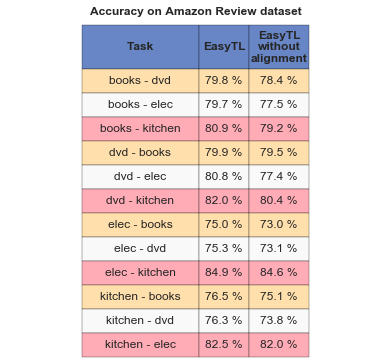

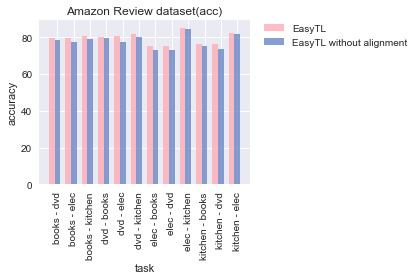

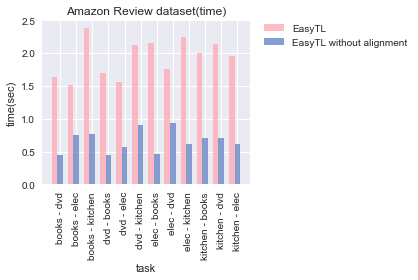

In [29]:
plot_result_table(task, EasyTL_Acc, EasyTL_without_alignment_Acc, 'Accuracy on Amazon Review dataset')
plot_bar_chart(task, EasyTL_Acc, EasyTL_without_alignment_Acc, 'Amazon Review dataset(acc)')
plot_bar_chart(task, EasyTL_time, EasyTL_without_alignment_time, 'Amazon Review dataset(time)', False)

### Office-Caltech dataset

In [30]:
datadir = 'Datasets/surf/'
domain = ['caltech10', 'amazon', 'webcam', 'dslr']
task = []
EasyTL_Acc = []
EasyTL_time = []
EasyTL_without_alignment_Acc = []
EasyTL_without_alignment_time = []

for i in range(len(domain)):
    for j in range(len(domain)):
        if i == j:
            continue
            
        print("{} - {}".format(domain[i], domain[j]))
        task.append("{} - {}".format(domain[i], domain[j]))
        
        mat1 = scipy.io.loadmat(datadir + '/{}_SURF_L10.mat'.format(domain[i]))
        mat2 = scipy.io.loadmat(datadir + '/{}_SURF_L10.mat'.format(domain[j]))

        Xs = mat1['fts']
        Ys = mat1['labels'] - 1

        Xt = mat2['fts']
        Yt = mat2['labels'] - 1

        Xs = Xs / np.tile(np.sum(Xs, axis=1).reshape(-1, 1), [1, Xs.shape[1]])
        Xs = scipy.stats.mstats.zscore(Xs)
        Xt = Xt / np.tile(np.sum(Xt, axis=1).reshape(-1, 1), [1, Xt.shape[1]])
        Xt = scipy.stats.mstats.zscore(Xt)

        Xs[np.isnan(Xs)] = 0
        Xt[np.isnan(Xt)] = 0

        t0 = time.time()
        _, Acc = EasyTL(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_time.append('{:.2f}'.format(t1 - t0))
        
        t0 = time.time()
        _, Acc = EasyTL_without_alignment(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL without alignment Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL without alignment Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_without_alignment_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_without_alignment_time.append('{:.2f}'.format(t1 - t0)) 
        print ('\n' + "-------------------------------------------------------" + '\n')

caltech10 - amazon
EasyTL Time Elapsed: 4.06 sec
EasyTL Acc: 52.6 %
EasyTL without alignment Time Elapsed: 1.09 sec
EasyTL without alignment Acc: 50.1 %

-------------------------------------------------------

caltech10 - webcam
EasyTL Time Elapsed: 3.20 sec
EasyTL Acc: 53.9 %
EasyTL without alignment Time Elapsed: 0.33 sec
EasyTL without alignment Acc: 49.5 %

-------------------------------------------------------

caltech10 - dslr
EasyTL Time Elapsed: 3.42 sec
EasyTL Acc: 51.6 %
EasyTL without alignment Time Elapsed: 0.17 sec
EasyTL without alignment Acc: 48.4 %

-------------------------------------------------------

amazon - caltech10
EasyTL Time Elapsed: 4.61 sec
EasyTL Acc: 42.3 %
EasyTL without alignment Time Elapsed: 1.33 sec
EasyTL without alignment Acc: 43.0 %

-------------------------------------------------------

amazon - webcam
EasyTL Time Elapsed: 3.22 sec
EasyTL Acc: 43.1 %
EasyTL without alignment Time Elapsed: 0.30 sec
EasyTL without alignment Acc: 40.7 %

-------

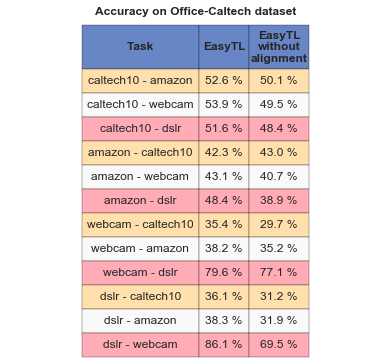

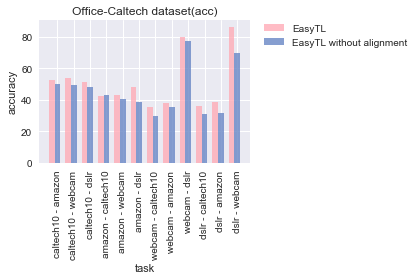

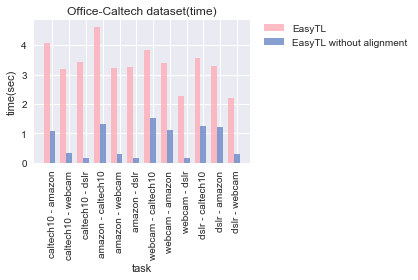

In [31]:
plot_result_table(task, EasyTL_Acc, EasyTL_without_alignment_Acc, 'Accuracy on Office-Caltech dataset')
plot_bar_chart(task, EasyTL_Acc, EasyTL_without_alignment_Acc, 'Office-Caltech dataset(acc)')
plot_bar_chart(task, EasyTL_time, EasyTL_without_alignment_time, 'Office-Caltech dataset(time)', False)

### Image-CLEF DA dataset

In [32]:
domain = ['c', 'i', 'p']
datadir = 'Datasets/imageCLEF_resnet50/'
task = []
EasyTL_Acc = []
EasyTL_time = []
EasyTL_without_alignment_Acc = []
EasyTL_without_alignment_time = []

for i in range(len(domain)):
    for j in range(len(domain)):
        if i == j:
            continue
        print("{} - {}".format(domain[i], domain[j]))
        task.append("{} - {}".format(domain[i], domain[j]))
        
        src = domain[i]
        tar = domain[j]

        x1file = "{}_{}.csv".format(src, src)
        x2file = "{}_{}.csv".format(src, tar)

        df1 = pd.read_csv(os.path.join(datadir, x1file), header=None)
        Xs = df1.values[:, :-1]
        Ys = df1.values[:, -1]

        df2 = pd.read_csv(os.path.join(datadir, x2file), header=None)
        Xt = df2.values[:, :-1]
        Yt = df2.values[:, -1]

        Xs = Xs / np.tile(np.sum(Xs, axis=1).reshape(-1, 1), [1, Xs.shape[1]])
        Xs = scipy.stats.mstats.zscore(Xs)
        Xt = Xt / np.tile(np.sum(Xt, axis=1).reshape(-1, 1), [1, Xt.shape[1]])
        Xt = scipy.stats.mstats.zscore(Xt)

        t0 = time.time()
        _, Acc = EasyTL(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_time.append('{:.2f}'.format(t1 - t0))
        
        t0 = time.time()
        _, Acc = EasyTL_without_alignment(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL without alignment Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL without alignment Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_without_alignment_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_without_alignment_time.append('{:.2f}'.format(t1 - t0)) 
        print ('\n' + "-------------------------------------------------------" + '\n')

c - i
EasyTL Time Elapsed: 24.72 sec
EasyTL Acc: 91.5 %
EasyTL without alignment Time Elapsed: 0.84 sec
EasyTL without alignment Acc: 85.5 %

-------------------------------------------------------

c - p
EasyTL Time Elapsed: 26.33 sec
EasyTL Acc: 77.7 %
EasyTL without alignment Time Elapsed: 0.86 sec
EasyTL without alignment Acc: 72.0 %

-------------------------------------------------------

i - c
EasyTL Time Elapsed: 26.72 sec
EasyTL Acc: 96.0 %
EasyTL without alignment Time Elapsed: 0.89 sec
EasyTL without alignment Acc: 93.3 %

-------------------------------------------------------

i - p
EasyTL Time Elapsed: 23.98 sec
EasyTL Acc: 78.7 %
EasyTL without alignment Time Elapsed: 0.75 sec
EasyTL without alignment Acc: 78.5 %

-------------------------------------------------------

p - c
EasyTL Time Elapsed: 26.87 sec
EasyTL Acc: 95.0 %
EasyTL without alignment Time Elapsed: 0.86 sec
EasyTL without alignment Acc: 91.0 %

-------------------------------------------------------

p - i

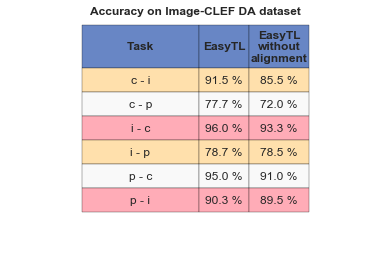

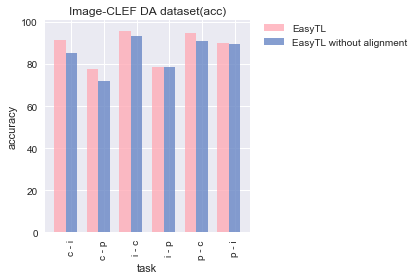

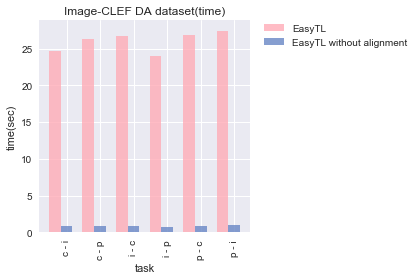

In [33]:
plot_result_table(task, EasyTL_Acc, EasyTL_without_alignment_Acc, 'Accuracy on Image-CLEF DA dataset')
plot_bar_chart(task, EasyTL_Acc, EasyTL_without_alignment_Acc, 'Image-CLEF DA dataset(acc)')
plot_bar_chart(task, EasyTL_time, EasyTL_without_alignment_time, 'Image-CLEF DA dataset(time)', False)

### Office-Home dataset

In [12]:
domain = ['Art', 'Clipart', 'Product', 'RealWorld']
datadir = 'Datasets/officehome_resnet50'

task = []
EasyTL_Acc = []
EasyTL_time = []
EasyTL_without_alignment_Acc = []
EasyTL_without_alignment_time = []

for i in range(len(domain)):
    for j in range(len(domain)):
        if i == j:
            continue
        print("{} - {}".format(domain[i], domain[j]))
        task.append("{} - {}".format(domain[i], domain[j]))
        
        src = domain[i]
        tar = domain[j]

        x1file = "{}_{}.csv".format(src, src)
        x2file = "{}_{}.csv".format(src, tar)

        df1 = pd.read_csv(os.path.join(datadir, x1file), header=None)
        Xs = df1.values[:, :-1]
        Ys = df1.values[:, -1]

        df2 = pd.read_csv(os.path.join(datadir, x2file), header=None)
        Xt = df2.values[:, :-1]
        Yt = df2.values[:, -1]

        Xs = Xs / np.tile(np.sum(Xs, axis=1).reshape(-1, 1), [1, Xs.shape[1]])
        Xs = scipy.stats.mstats.zscore(Xs)
        
        Xt = Xt / np.tile(np.sum(Xt, axis=1).reshape(-1, 1), [1, Xt.shape[1]])
        Xt = scipy.stats.mstats.zscore(Xt)

        t0 = time.time()
        _, Acc = EasyTL(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_time.append('{:.2f}'.format(t1 - t0))
        
        t0 = time.time()
        _, Acc = EasyTL_without_alignment(Xs, Ys, Xt, Yt)
        t1 = time.time()
        print("EasyTL without alignment Time Elapsed: {:.2f} sec".format(t1 - t0))
        print('EasyTL without alignment Acc: {:.1f} %'.format(Acc * 100)) 
        EasyTL_without_alignment_Acc.append('{:.1f} %'.format(Acc * 100))
        EasyTL_without_alignment_time.append('{:.2f}'.format(t1 - t0)) 
        print ('\n' + "-------------------------------------------------------" + '\n')

In [ ]:
plot_result_table(task, EasyTL_Acc, EasyTL_without_alignment_Acc, 'Accuracy on Office-Home DA dataset')
plot_bar_chart(task, EasyTL_Acc, EasyTL_without_alignment_Acc, 'Office-Home DA dataset(acc)')
plot_bar_chart(task, EasyTL_time, EasyTL_without_alignment_time, 'Office-Home DA dataset(time)', False)